Problem:
The data set consists of records of customers review regarding Amazon's Alexa. Each customer's review has been categorized into Postive and Negatve based on the reviews given.

Objective:
The objective of this analysis is to build a predictive classification model on text data highly processed by scpCy and predict future instances.

##Import Packages

In [3]:
import pandas as pd
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

##Import Data

In [4]:
#Read the data set
df= pd.read_csv('amazon_alexa.tsv', sep='\t')

In [5]:
#First five observations
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
#Shape of the dataset
df.shape

(3150, 5)

In [7]:
#Count of output feature
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

##Tokenization

In [8]:
#Create list of punctuation marks
import string
punctuations=string.punctuation

#Create list of stopwords
nlp=spacy.load('en')
stop_words= spacy.lang.en.stop_words.STOP_WORDS

#Load English tokenizer, tagger, parser, NER and word vectors
parser=English()

#Create tokenizer function
def spacy_tokenizer(sentence):
  #Creating our token object, which is used to create documents with linguistic annotations.
  mytokens=parser(sentence)
  #Lemmatizing each token and converting each token into lowercase
  mytokens=[word.lemma_.lower().strip() if word.lemma_!='-PRON-' else word.lower_ for word in mytokens]
  #Removing stopwords
  mytokens= [word for word in mytokens if word not in stop_words and word not in punctuations]
  #Return preprocessed list of tokens
  return mytokens

##Custom Transformer using spaCy

In [9]:
#To further clean our text data, we’ll also want to create a custom transformer for removing initial and end spaces and converting text into lower case.
from sklearn.base import TransformerMixin
class predictors(TransformerMixin):
  def transform(self,X, **transform_params):
    return [clean_text(text) for text in X]
  
  def fit(self,X,y=None, **fit_params):
    return self
  
  def get_params(self, deep=True):
    return {}
#Basic function to clean the text
def clean_text(text):
  #Removing spaces and converting text into lowercase
  return text.strip().lower()

##Vectorization

In [10]:
#We need to perform feature vectorization in order to transform word tokens into numbers. We can do it using tf-idf ,Bag of Words.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vector= CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,3))
tfidf_vector= TfidfVectorizer(tokenizer=spacy_tokenizer)

##Train Test Split

In [11]:
#Spliting data into train and test
from sklearn.model_selection import train_test_split
X= df['verified_reviews']
y=df['feedback']
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.25)

##Pipeline

In [12]:
#We will use pipeline to integrate the entire modeling technique.
#Pipeline 1
#Decision Tree with GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
classifier= DecisionTreeClassifier(class_weight='balanced')
parameters={'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}
clf=GridSearchCV(classifier,parameters)

In [13]:
#Pipeline using tfidf
pipe1= Pipeline([('cleaner', predictors()),
                 ('vectorizer',tfidf_vector),
                 ('classifier', classifier)])
pipe1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f6bb1c906a0>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                   

Accuracy: 0.8705583756345178
Precision: 0.8908839779005525
Recall: 0.9655688622754491


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


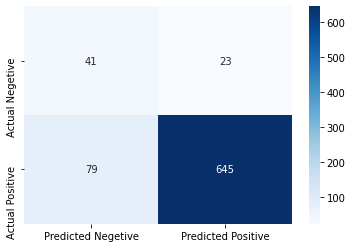

In [14]:
#Evaluation of GridSearchCV Decision Tree model
from sklearn import metrics
predicted= pipe1.predict(X_test)
print('Accuracy:',metrics.accuracy_score(predicted,y_test))
print('Precision:',metrics.precision_score(predicted,y_test))
print('Recall:',metrics.recall_score(predicted,y_test))

import seaborn as sns
import matplotlib.pyplot as plt
cfm=metrics.confusion_matrix(y_test,predicted)
lbl1=['Predicted Negetive', 'Predicted Positive']
lbl2=['Actual Negetive', 'Actual Positive']
sns.heatmap(cfm, annot=True, cmap='Blues',fmt='d',xticklabels=lbl1,yticklabels=lbl2)
plt.show()

In [15]:
#Pipeline 2
#Decision Tree without GridSearchCV
pipe2= Pipeline([('cleaner',predictors()),
                 ('vectorizer',bow_vector),
                 ('classifier',clf)])
pipe2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f6bbbef1fd0>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                                               min_weight_fraction_leaf=0.0,
  

##Evaluation

Accuracy: 0.6802030456852792
Precision: 0.6712707182320442
Recall: 0.972


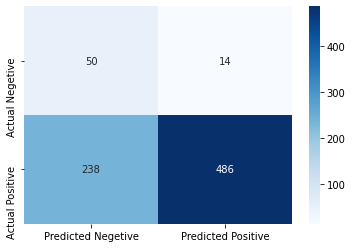

In [16]:
##Evaluation of simple Decision Tree model
predicted2= pipe2.predict(X_test)
print('Accuracy:',metrics.accuracy_score(predicted2,y_test))
print('Precision:',metrics.precision_score(predicted2,y_test))
print('Recall:',metrics.recall_score(predicted2,y_test))

cfm=metrics.confusion_matrix(y_test,predicted2)
lbl1=['Predicted Negetive', 'Predicted Positive']
lbl2=['Actual Negetive', 'Actual Positive']
sns.heatmap(cfm, annot=True, cmap='Blues',fmt='d',xticklabels=lbl1,yticklabels=lbl2)
plt.show()

In [17]:
#Pipeline 3
#SVM with GridSearchCV
from sklearn.svm import SVC
svc=SVC(class_weight='balanced')
params1={'kernel':['linear','rbf','poly','sigmoid'],'C':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
gs_svc=GridSearchCV(svc,params1)

In [18]:
#Pipeline using tfidf
pipe3= Pipeline([('cleaner', predictors()),
                 ('vectorizer',tfidf_vector),
                 ('classifier', gs_svc)])
pipe3.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f6babebd240>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False

Accuracy: 0.934010152284264
Precision: 0.9709944751381215
Recall: 0.9577656675749319


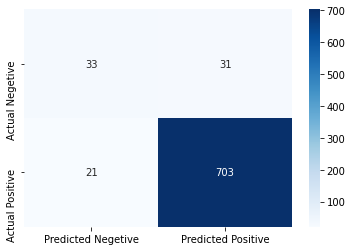

In [19]:
#Evaluation of GridSearchCV SVM
predicted3= pipe3.predict(X_test)
print('Accuracy:',metrics.accuracy_score(predicted3,y_test))
print('Precision:',metrics.precision_score(predicted3,y_test))
print('Recall:',metrics.recall_score(predicted3,y_test))

cfm=metrics.confusion_matrix(y_test,predicted3)
lbl1=['Predicted Negetive', 'Predicted Positive']
lbl2=['Actual Negetive', 'Actual Positive']
sns.heatmap(cfm, annot=True, cmap='Blues',fmt='d',xticklabels=lbl1,yticklabels=lbl2)
plt.show()